In [66]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
from cosima_cookbook import explore

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.path as mpath
from matplotlib import ticker, cm
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
import glob,os
import climtas.nci
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmcrameri
import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.signal import butter, lfilter, filtfilt
from scipy.signal import freqs

import sys
sys.path.append("/g/data/x77/ps7863/python_scripts")
import helper_functions as helper

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


from dask.distributed import Client

figdir = '/g/data/x77/ps7863/figures/AABW_variability/perturb_expts'

In [2]:
climtas.nci.GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34807/status,
Dashboard: /proxy/34807/status,Workers: 48
Total threads: 48,Total memory: 190.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36571,Workers: 48
Dashboard: /proxy/34807/status,Total threads: 48
Started: Just now,Total memory: 190.00 GiB
Comm: tcp://127.0.0.1:37981,Total threads: 1
Dashboard: /proxy/37977/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:43961,


2025-01-24 15:03:36,054 - tornado.application - ERROR - Uncaught exception GET /individual-scheduler-system/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='gadi-cpu-clx-1470.gadi.nci.org.au:15459', method='GET', uri='/individual-scheduler-system/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/tornado/web.py", line 1790, in _execute
    result = await result
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/tornado/websocket.py", line 273, in get
    await self.ws_connection.accept_connection(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/tornado/websocket.py", line 863, in accept_connection
    await self._accept_connection(handler)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/tornado/websocket.py", line 946, in

In [3]:
db = '/g/data/x77/ps7863/data/perturb_expts.db'
session = cc.database.create_session(db)

In [ ]:
directory_list=['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v13_ryf9091_easterlies_down10',
                '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/',
                '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v13_ryf9091_ssp245/',
                '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v13_ryf9091_ssp245_mw/', 
                '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v13_ryf9091_ssp585/',
                '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/'
                '/g/data/e14/hd4873/access-om2-01/01deg_jra55v13_ryf9091_ssp585_mw/',
                '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v13_ryf9091/',
                '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v13_ryf9091/01deg_jra55v13_ryf9091_qian_wthmp'
               ]
cc.database.build_index(directory_list, session)

# '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v13_ryf9091/',


In [49]:
dbx = explore.DatabaseExplorer(session=session)
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

In [4]:
control = '01deg_jra55v13_ryf9091'
east_down = '01deg_jra55v13_ryf9091_easterlies_down10'
east_up = '01deg_jra55v13_ryf9091_easterlies_up10'
ssp_245 = '01deg_jra55v13_ryf9091_ssp245'
ssp_245_mw = '01deg_jra55v13_ryf9091_ssp245_mw'
ssp_585 = '01deg_jra55v13_ryf9091_ssp585'
ssp_585_mw = '01deg_jra55v13_ryf9091_ssp585_mw'

In [5]:
fp = '/g/data/x77/ps7863/data/AABW_variability/temperature_in_the_bottom_500m_01deg_jra55v13_ryf9091_2150-2164.nc'
temp_control = xr.open_dataset(fp)
fp = '/g/data/x77/ps7863/data/AABW_variability/temperature_in_the_bottom_500m_01deg_jra55v13_ryf9091_easterlies_up10_2150-2164.nc'
temp_eastup = xr.open_dataset(fp)
fp = '/g/data/x77/ps7863/data/AABW_variability/temperature_in_the_bottom_500m_01deg_jra55v13_ryf9091_easterlies_down10_2150-2164.nc'
temp_eastdown = xr.open_dataset(fp)
fp = '/g/data/x77/ps7863/data/AABW_variability/temperature_in_the_bottom_500m_01deg_jra55v13_ryf9091_ssp245_2150-2164.nc'
temp_ssp245 = xr.open_dataset(fp)
fp = '/g/data/x77/ps7863/data/AABW_variability/temperature_in_the_bottom_500m_01deg_jra55v13_ryf9091_ssp245_mw_2150-2164.nc'
temp_ssp245_mw = xr.open_dataset(fp)



In [6]:
temp_control['time'] = temp_control.indexes['time'].to_datetimeindex()
temp_eastdown['time'] = temp_eastdown.indexes['time'].to_datetimeindex()
temp_eastup['time'] = temp_eastup.indexes['time'].to_datetimeindex()

In [7]:
temp_control = temp_control.to_dataarray().squeeze()
temp_eastdown = temp_eastdown.to_dataarray().squeeze()
temp_eastup = temp_eastup.to_dataarray().squeeze()
# temp_eastdown = temp_eastdown['__xarray_dataarray_variable__']
# temp_eastup = temp_eastup['__xarray_dataarray_variable__']
# temp_ssp245 = temp_ssp245['__xarray_dataarray_variable__']
# temp_ssp245_mw = temp_ssp245_mw['__xarray_dataarray_variable__']

In [8]:
mask_nan = np.isnan(temp_control[0,...])
temp_control = temp_control.where(~mask_nan,0)
mask_nan = np.isnan(temp_eastdown[0,...])
temp_eastdown = temp_eastdown.where(~mask_nan,0)
mask_nan = np.isnan(temp_eastup[0,...])
temp_eastup = temp_eastup.where(~mask_nan, 0)

In [9]:
K = 273.15
temp_control = temp_control - K 
temp_eastdown = temp_eastdown - K
temp_eastup = temp_eastup - K
# temp_ssp245 = temp_ssp245 - K
# temp_ssp245_mw = temp_ssp245_mw - K

In [10]:
lon_slice = slice(80-360, 190-360)
lat_slice = slice(-82, -55)

degree =  u'\N{DEGREE SIGN}'

In [57]:
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

In [58]:
shelf_mask = ht > 1000
shelf_mask = shelf_mask.astype(bool)
masked_shelf = shelf_mask.where(shelf_mask==0, np.nan)
shelf_mask = shelf_mask.where(shelf_mask==1, np.nan)
shelf_mask

<xarray.DataArray 'ht' (yt_ocean: 584, xt_ocean: 1100)> Size: 5MB
dask.array<where, shape=(584, 1100), dtype=float64, chunksize=(584, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 9kB -279.9 -279.8 -279.7 ... -170.1 -170.0
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01
    geolon_t  (yt_ocean, xt_ocean) float32 3MB dask.array<chunksize=(584, 900), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 3MB dask.array<chunksize=(584, 900), meta=np.ndarray>

In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [60]:
land_50m = cfeature.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="grey", linewidth=0.5
)

In [61]:
xt_ocean = ht.xt_ocean
yt_ocean = ht.yt_ocean

In [62]:
X, Y = np.meshgrid(xt_ocean, yt_ocean)
X = xr.DataArray(X, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])
Y = xr.DataArray(Y, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])

In [63]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [64]:
# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [65]:
first_year = 2150
last_year = 2164
start_time = f'31-01-{first_year}'
end_time = f'31-12-{last_year}'
time_slice = slice(start_time, end_time)

In [11]:
temp_control_clim = temp_control.groupby('time.month').mean('time')
temp_eastdown_clim = temp_eastdown.groupby('time.month').mean('time')
temp_eastup_clim = temp_eastup.groupby('time.month').mean('time')

In [28]:
temp_control_deseasoned = temp_control.groupby('time.month') - temp_control_clim
temp_eastdown_deseasoned = temp_eastdown.groupby('time.month') - temp_eastdown_clim
temp_eastup_deseasoned = temp_eastup.groupby('time.month') - temp_eastup_clim

temp_control_rolling_mean = temp_control.rolling(time=12, min_periods=1, center=True).mean('time')
temp_eastdown_rolling_mean = temp_eastdown.rolling(time=12, min_periods=1, center=True).mean('time')
temp_eastup_rolling_mean = temp_eastup.rolling(time=12, min_periods=1, center=True).mean('time')

In [35]:
# Define a Butterworth low-pass filter
def low_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=0)  # Apply along the time axis

# Example usage with xarray
def apply_low_pass_filter(da, cutoff, fs, order=4):
    return xr.apply_ufunc(
        low_pass_filter,
        da,
        cutoff,
        fs,
        order,
        input_core_dims=[['time'], [], [], []],  # Apply along the 'time' dimension
        output_core_dims=[['time']],
        vectorize=True,  # Apply across other dimensions
        dask='parallelized',  # Enable Dask if needed for large datasets
        output_dtypes=[da.dtype]
    )

In [39]:
cutoff_frequency = 1 / 12  # Assuming monthly data, cutoff is 12 months
sampling_frequency = 1  # Sampling frequency for monthly data is 1 cycle/month

# Apply the filter to age_control
temp_control_filtered = apply_low_pass_filter(temp_control, cutoff_frequency, sampling_frequency)
temp_eastdown_filtered = apply_low_pass_filter(temp_eastdown, cutoff_frequency, sampling_frequency)
temp_eastup_filtered = apply_low_pass_filter(temp_eastup, cutoff_frequency, sampling_frequency)

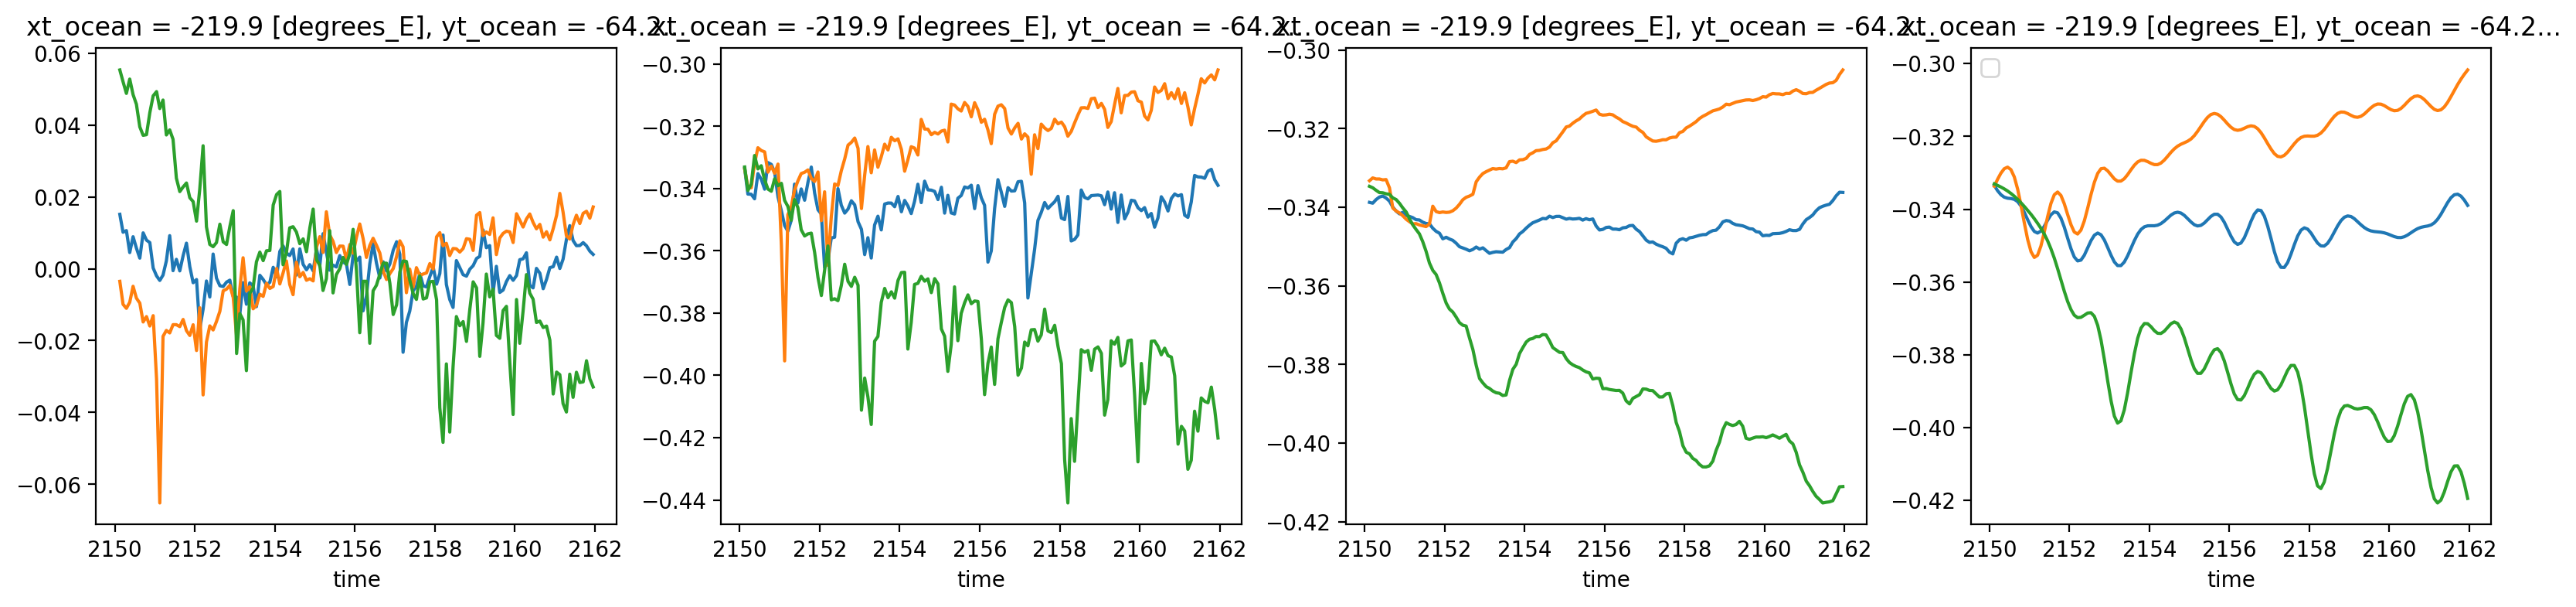

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))

temp_control_deseasoned.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[0], label='control')
temp_eastdown_deseasoned.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[0], label='easterlies-10')
temp_eastup_deseasoned.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[0], label='easterlies+10')
plt.legend()

temp_control.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[1], label='control')
temp_eastdown.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[1], label='easterlies-10')
temp_eastup.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[1], label='easterlies+10')

temp_control_rolling_mean.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[2], label='control')
temp_eastdown_rolling_mean.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[2], label='easterlies-10')
temp_eastup_rolling_mean.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[2], label='easterlies+10')

temp_control_filtered.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[3], label='control')
temp_eastdown_filtered.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[3], label='easterlies-10')
temp_eastup_filtered.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[3], label='easterlies+10')

In [41]:
temp_control_mean = helper.annual_mean_from_monthly(temp_control_rolling_mean)
temp_eastdown_mean = helper.annual_mean_from_monthly(temp_eastdown_rolling_mean)
temp_eastup_mean = helper.annual_mean_from_monthly(temp_eastup_rolling_mean)

In [42]:
temp_eastdown_anom = (temp_eastdown_mean - temp_control_mean)
temp_eastup_anom = (temp_eastup_mean - temp_control_mean)

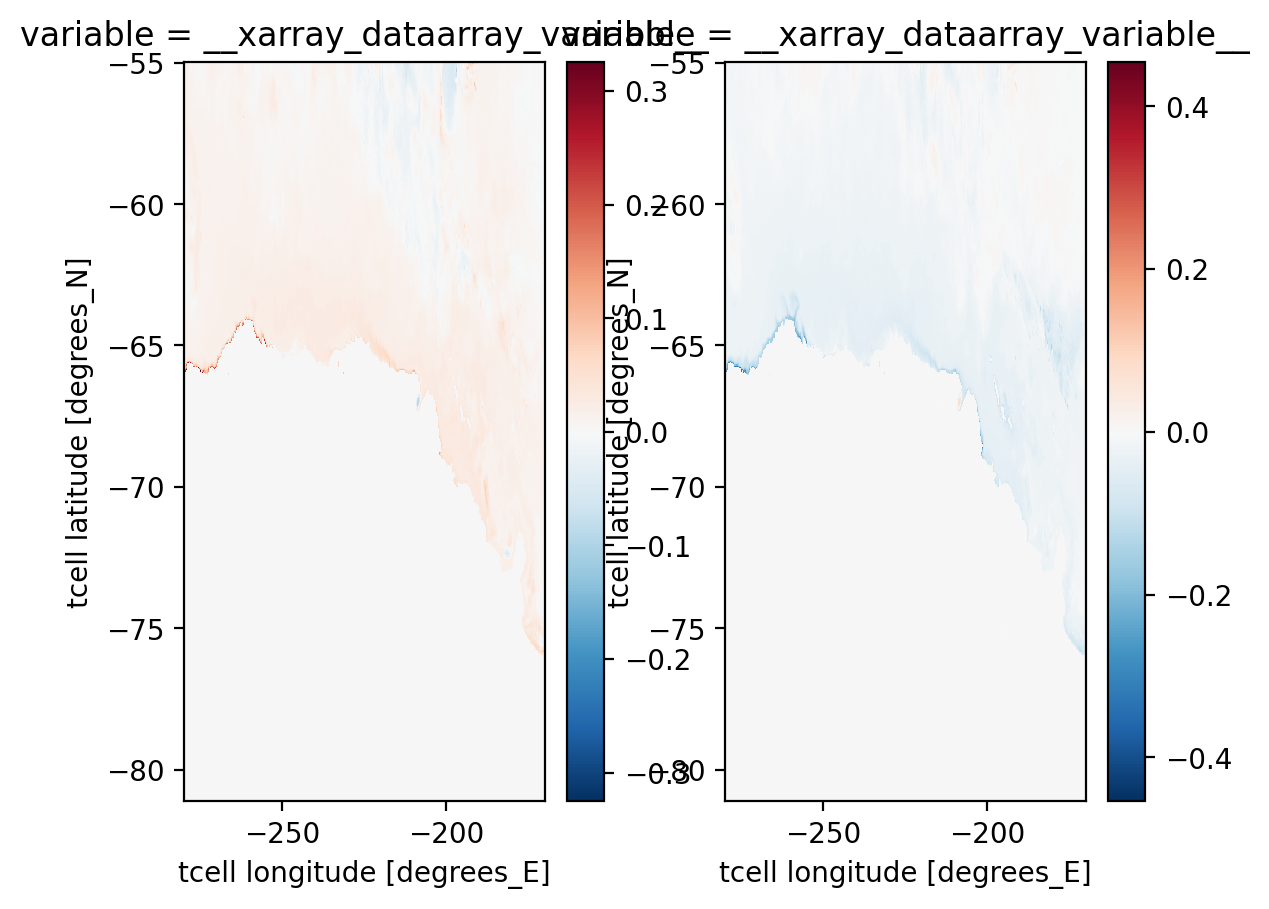

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2)
temp_eastdown_anom.plot(ax=axes[0], cmap='RdBu_r')
temp_eastup_anom.plot(ax=axes[1], cmap='RdBu_r')

In [49]:
anomaly_eastdown= temp_eastdown_anom
anomaly_eastdown_time_series = temp_eastdown_rolling_mean - temp_control_rolling_mean
condition_eastdown_15 = abs(anomaly_eastdown_time_series) >= abs(0.15*anomaly_eastdown)
threshold_eastdown_15 = anomaly_eastdown_time_series.where(condition_eastdown_15)
eastdown_time_indices_15 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    threshold_eastdown_15,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
eastdown_timing_15 = anomaly_eastdown_time_series.isel(time=eastdown_time_indices_15).time.dt.date
eastdown_timing_15

<xarray.DataArray 'date' (yt_ocean: 584, xt_ocean: 1100)> Size: 5MB
array([[datetime.date(2150, 2, 15), datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       [datetime.date(2150, 2, 15), datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       [datetime.date(2150, 2, 15), datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       ...,
       [datetime.date(2150, 2, 15), datetime.date(2150, 4, 16),
        datetime.date(2150, 3, 16), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       [datetime.date(2150, 2, 15), datetime.date(2150, 4, 16),
        datetime.date(2150, 4, 16), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       [datetime.date(2150, 2, 15), datetime.date(2150, 4, 16),
        datetime.date(2150, 4, 16), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)]],
      dtype=object)
Coordinates:
  * xt_ocean  (xt_ocean) float64 9kB -279.9 -279.8 -279.7 ... -170.1 -170.0
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01
    time      (yt_ocean, xt_ocean) datetime64[ns] 5MB 2150-02-15 ... 2150-02-15
    geolon_t  (yt_ocean, xt_ocean) float32 3MB nan nan nan ... -170.1 -170.1
    geolat_t  (yt_ocean, xt_ocean) float32 3MB nan nan nan ... -55.01 -55.01
    variable  <U29 116B '__xarray_dataarray_variable__'

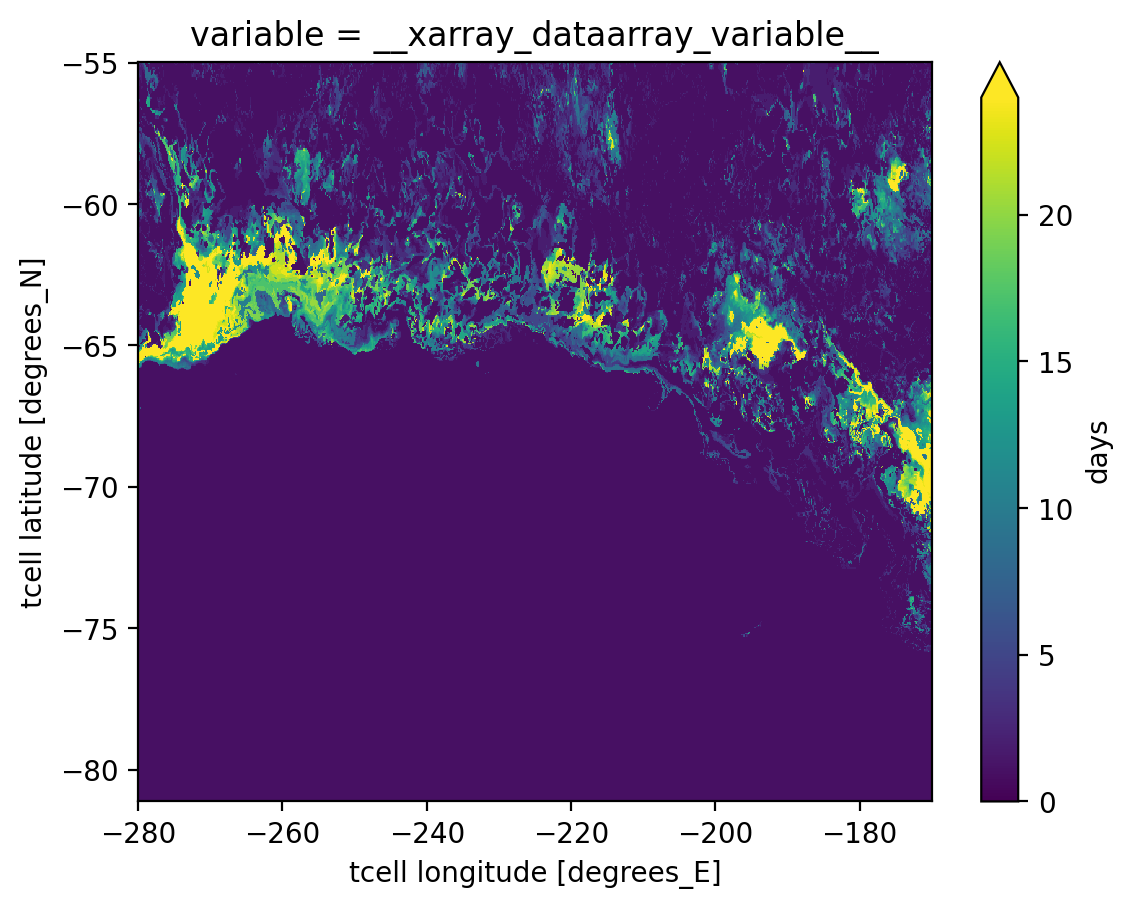

In [50]:
start_time = datetime.date(2150, 1, 16)
timing_eastdown = (eastdown_timing_15 - start_time).dt.days/30
timing_eastdown.plot(vmin=0, vmax=24)

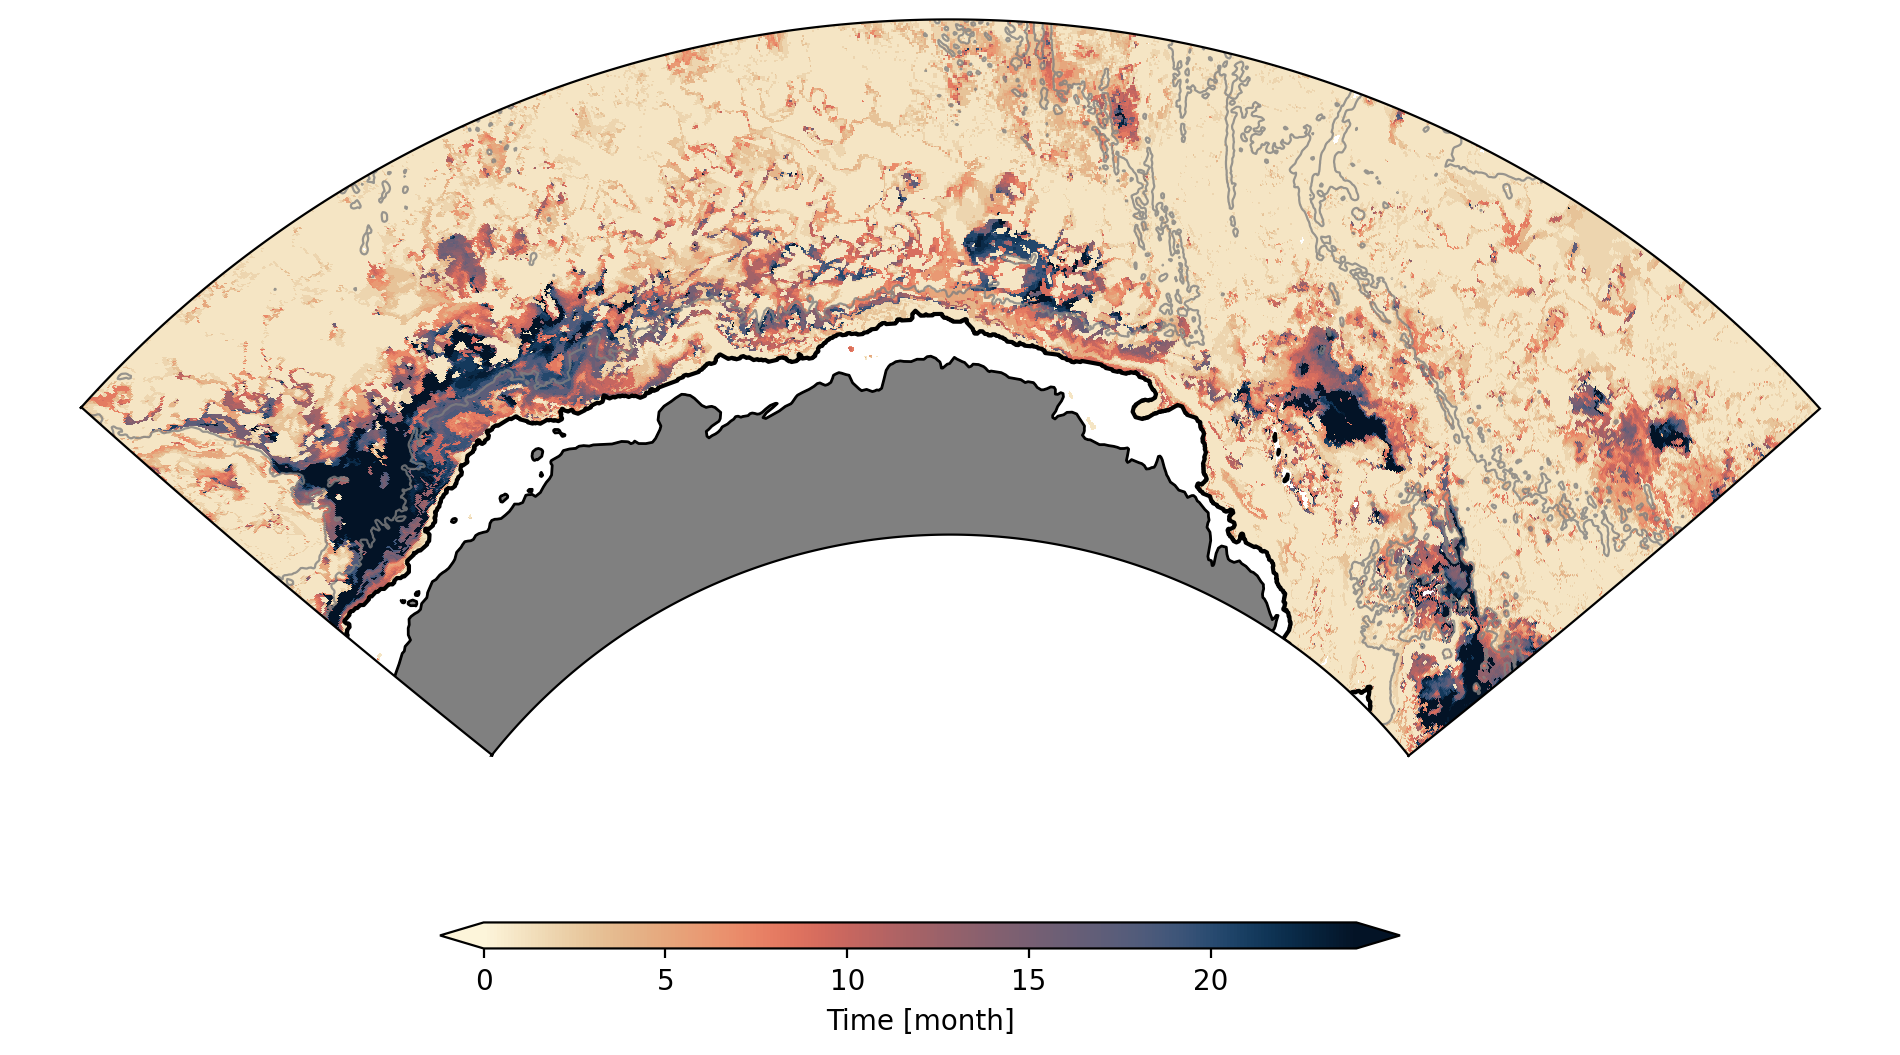

In [67]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -72
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=12, vmax=24)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, timing_eastdown*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(f'Time [month]')

plt.savefig(f'{figdir}/timing_of_temp_anomaly-{east_down}_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


<xarray.DataArray ()> Size: 8B
array(0.01508734)
Coordinates:
    xt_ocean  float64 8B -219.9
    yt_ocean  float64 8B -64.2
    geolon_t  float32 4B -219.9
    geolat_t  float32 4B -64.2
    variable  <U29 116B '__xarray_dataarray_variable__'

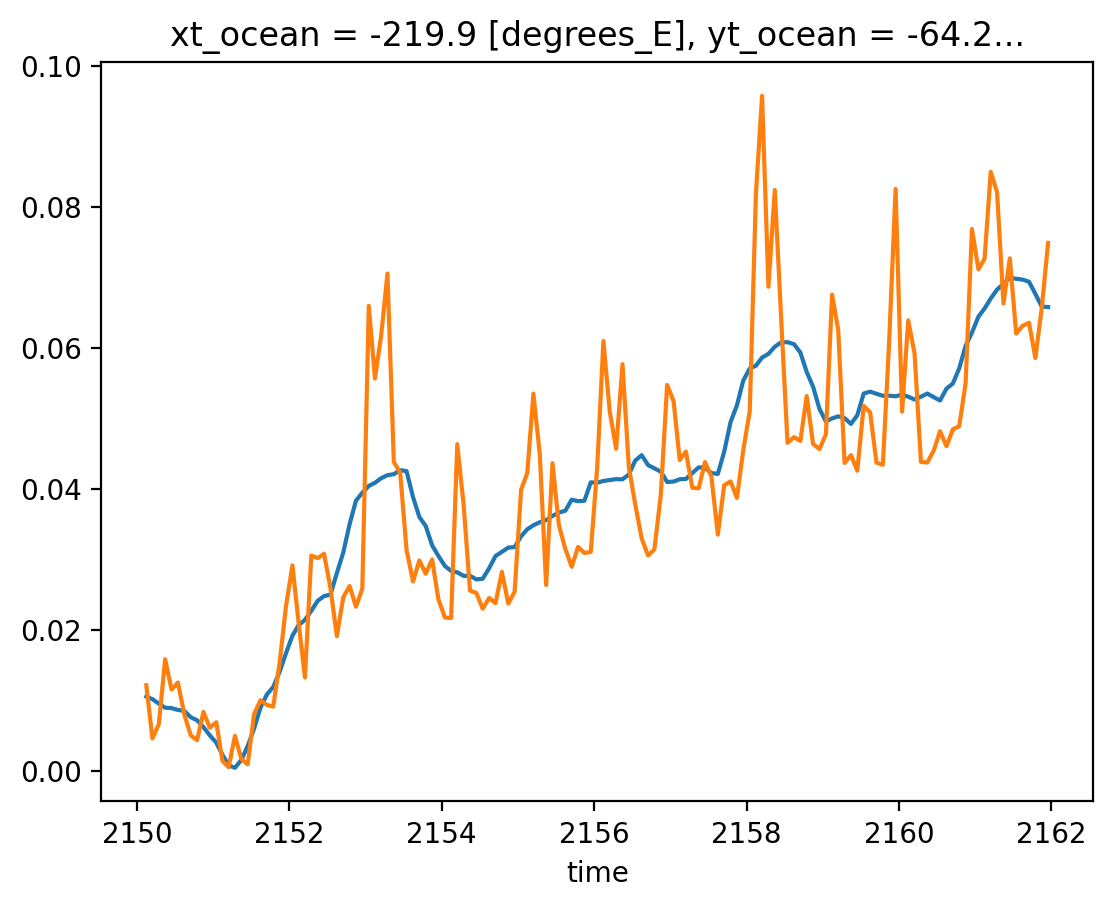

In [84]:
abs(anomaly_eastup_time_series.isel(xt_ocean=600, yt_ocean=400)).plot()
abs(temp_eastup.isel(xt_ocean=600, yt_ocean=400) - temp_control_mean.isel(xt_ocean=600, yt_ocean=400)).plot()
abs(0.4*anomaly_eastup.isel(xt_ocean=600, yt_ocean=400))

In [85]:
abs(anomaly_eastup_time_series.isel(xt_ocean=600, yt_ocean=400)) >= abs(0.4*anomaly_eastup.isel(xt_ocean=600, yt_ocean=400))

<xarray.DataArray (time: 143)> Size: 143B
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])
Coordinates:
    xt_ocean  float64 8B -219.9
    yt_ocean  float64 8B -64.2
  * time      (time) datetime64[ns] 1kB 2150-02-15 ... 2161-12-16T12:00:00
    geolon_t  float32 4B -219.9
    geolat_t  float32 4B -64.2
    variable  <U29 116B '__xarray_dataarray_variable__'

In [99]:
anomaly_eastup= helper.annual_mean_from_monthly(temp_eastup_rolling_mean) - temp_control_mean
anomaly_eastup_time_series = temp_eastup_rolling_mean - temp_control_mean
condition_eastup_60 = abs(anomaly_eastup_time_series) >= abs(0.4*anomaly_eastup)
threshold_eastup_60 = anomaly_eastup_time_series.where(condition_eastup_60)
eastup_time_indices_60 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    threshold_eastup_60,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
eastup_timing_60 = anomaly_eastup_time_series.isel(time=eastup_time_indices_60).time.dt.date
eastup_timing_60

<xarray.DataArray 'date' (yt_ocean: 584, xt_ocean: 1100)> Size: 5MB
array([[datetime.date(2150, 2, 15), datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       [datetime.date(2150, 2, 15), datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       [datetime.date(2150, 2, 15), datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       ...,
       [datetime.date(2150, 11, 16), datetime.date(2150, 12, 16),
        datetime.date(2150, 11, 16), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       [datetime.date(2150, 12, 16), datetime.date(2150, 12, 16),
        datetime.date(2150, 11, 16), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)],
       [datetime.date(2150, 12, 16), datetime.date(2150, 12, 16),
        datetime.date(2150, 11, 16), ..., datetime.date(2150, 2, 15),
        datetime.date(2150, 2, 15), datetime.date(2150, 2, 15)]],
      dtype=object)
Coordinates:
  * xt_ocean  (xt_ocean) float64 9kB -279.9 -279.8 -279.7 ... -170.1 -170.0
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01
    time      (yt_ocean, xt_ocean) datetime64[ns] 5MB 2150-02-15 ... 2150-02-15
    geolon_t  (yt_ocean, xt_ocean) float32 3MB nan nan nan ... -170.1 -170.1
    geolat_t  (yt_ocean, xt_ocean) float32 3MB nan nan nan ... -55.01 -55.01
    variable  <U29 116B '__xarray_dataarray_variable__'

In [100]:
timing_eastup = (eastup_timing_60  - start_time).dt.days / 30

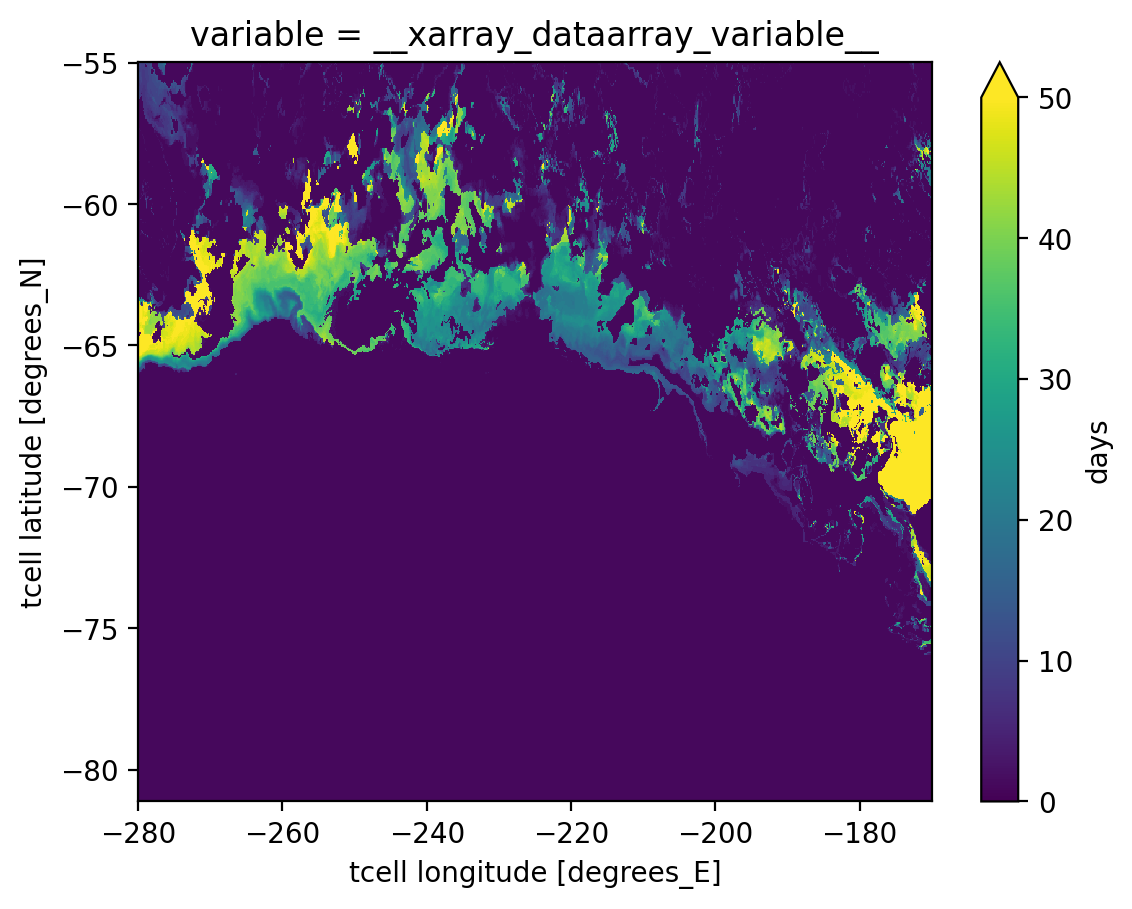

In [101]:
timing_eastup.plot(vmin=0, vmax=50)

In [25]:
temp_anom_eastdown = temp_control_mean - temp_eastdown_mean
# temp_anom_eastup = helper.annual_mean_from_monthly(temp_control_rolling_mean) - helper.annual_mean_from_monthly(temp_eastup_rolling_mean)

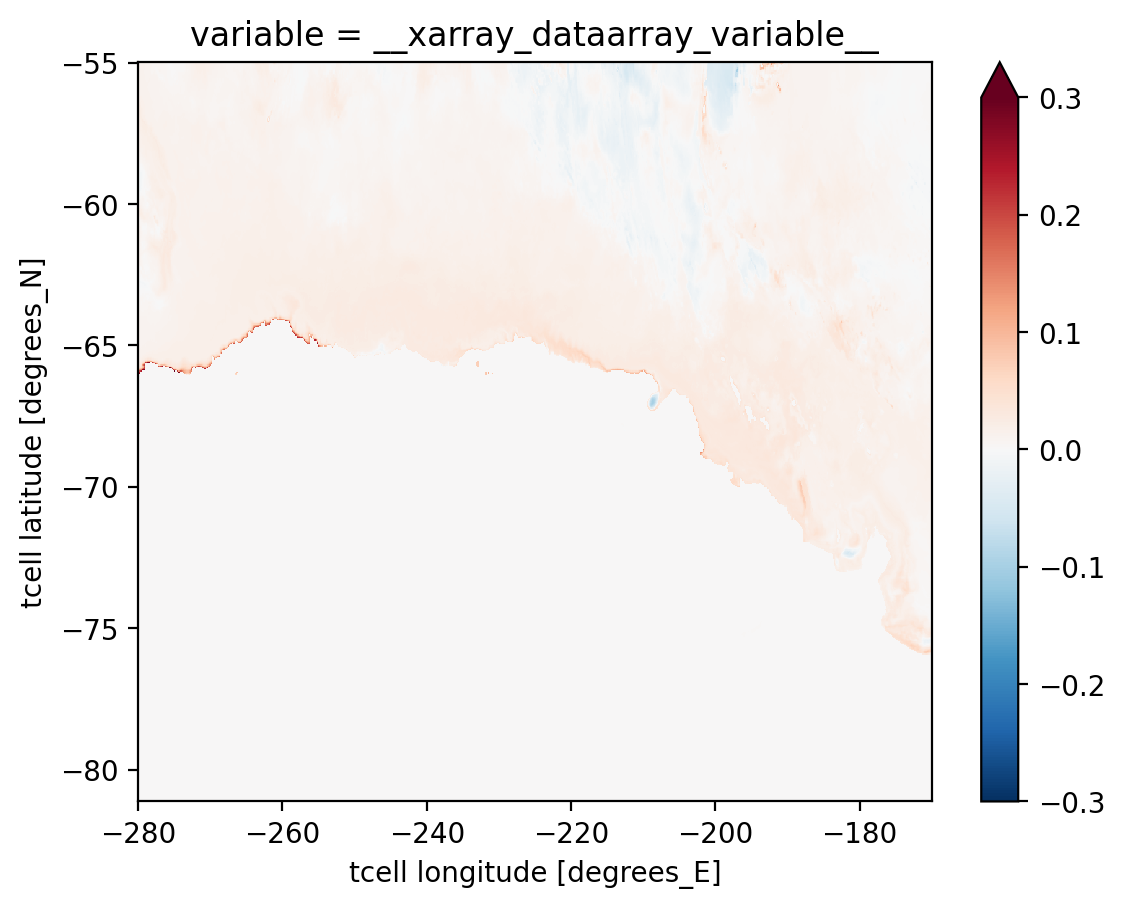

In [125]:
fig, axes = plt.subplots(ncols=1, nrows=1)
(temp_eastdown_mean-temp_control_mean).plot(vmin=-0.3, vmax=0.3, cmap='RdBu_r')
# axes[0].scatter(temp_eastdown_rolling_mean.isel(xt_ocean=600, yt_ocean=400).xt_ocean, temp_eastdown_rolling_mean.isel(xt_ocean=600, yt_ocean=400).yt_ocean)
# temp_anom_eastup.plot(ax=axes[1], vmin=-0.3, vmax=0.3, cmap='RdBu')

In [39]:
condition = (temp_control_rolling_mean-temp_eastdown_rolling_mean) <= temp_anom_eastdown * 0.3
eastdown_threshold_15 = (temp_control_rolling_mean-temp_eastdown_rolling_mean).where(condition)



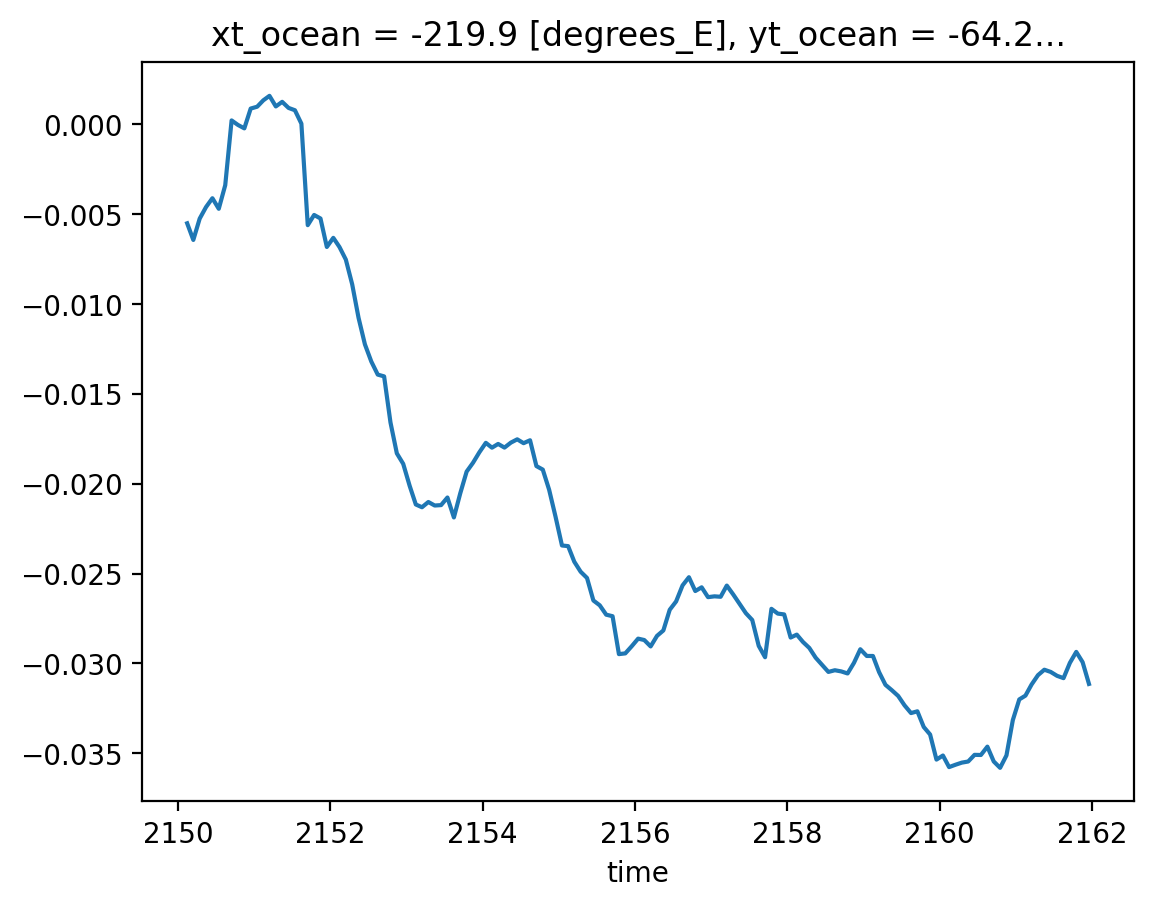

In [28]:
(temp_control_rolling_mean-temp_eastdown_rolling_mean).isel(xt_ocean=600, yt_ocean=400).plot()

In [35]:
(temp_control_rolling_mean.isel(xt_ocean=600, yt_ocean=400)-temp_eastdown_rolling_mean.isel(xt_ocean=600, yt_ocean=400)).where(condition.isel(xt_ocean=600, yt_ocean=400))

<xarray.DataArray (time: 143)> Size: 1kB
array([-0.00550268, -0.00642884, -0.00524236, -0.00459784, -0.00410601,
       -0.00469474, -0.00338077,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -0.00560596,
       -0.00503848, -0.00523469, -0.00681973, -0.00631204, -0.0068221 ,
       -0.00752074, -0.00889916, -0.01076461, -0.01224145, -0.01319407,
       -0.01392511, -0.01402434, -0.01658721, -0.01830885, -0.01889139,
       -0.02011886, -0.02115472, -0.02130914, -0.02101699, -0.02121278,
       -0.02119001, -0.02076725, -0.02187718, -0.02053327, -0.01932665,
       -0.01883443, -0.0182506 , -0.01772386, -0.01799296, -0.01778499,
       -0.01798821, -0.01771209, -0.01752805, -0.01774192, -0.01758028,
       -0.01901722, -0.01921322, -0.02033618, -0.0218267 , -0.02343829,
       -0.0234729 , -0.02434008, -0.02489856, -0.02524533, -0.02649856,
       -0.02676758, -0.02728964, -0.02737446, -0.02948532, -0.02944375,
       -0.0290503 , -0.02862339, -0.02870092, -0.02905687, -0.0284703 ,
       -0.0281662 , -0.02701636, -0.02655447, -0.02565926, -0.02520486,
       -0.02597316, -0.02576641, -0.02631402, -0.02626826, -0.02629276,
       -0.025669  , -0.02615902, -0.02668309, -0.02720693, -0.02758573,
       -0.02902296, -0.02965879, -0.026964  , -0.02722992, -0.02727468,
       -0.02856314, -0.0283991 , -0.02880717, -0.02914141, -0.02968504,
       -0.03007729, -0.03047636, -0.03038237, -0.03044767, -0.03056213,
       -0.02997318, -0.02921281, -0.0295882 , -0.02958847, -0.03048845,
       -0.03119472, -0.03149353, -0.03181431, -0.03233734, -0.03276665,
       -0.03266863, -0.03354136, -0.03395918, -0.03535691, -0.03512986,
       -0.03577431, -0.03564403, -0.03552564, -0.03546334, -0.03509273,
       -0.03509981, -0.03463634, -0.03546064, -0.03581587, -0.03512318,
       -0.03315794, -0.03200676, -0.03179521, -0.03117472, -0.03065723,
       -0.03035329, -0.03047613, -0.03069372, -0.03082246, -0.02997168,
       -0.02936204, -0.02993323, -0.03114577])
Coordinates:
    xt_ocean  float64 8B -219.9
    yt_ocean  float64 8B -64.2
  * time      (time) datetime64[ns] 1kB 2150-02-15 ... 2161-12-16T12:00:00
    geolon_t  float32 4B -219.9
    geolat_t  float32 4B -64.2
    variable  <U29 116B '__xarray_dataarray_variable__'

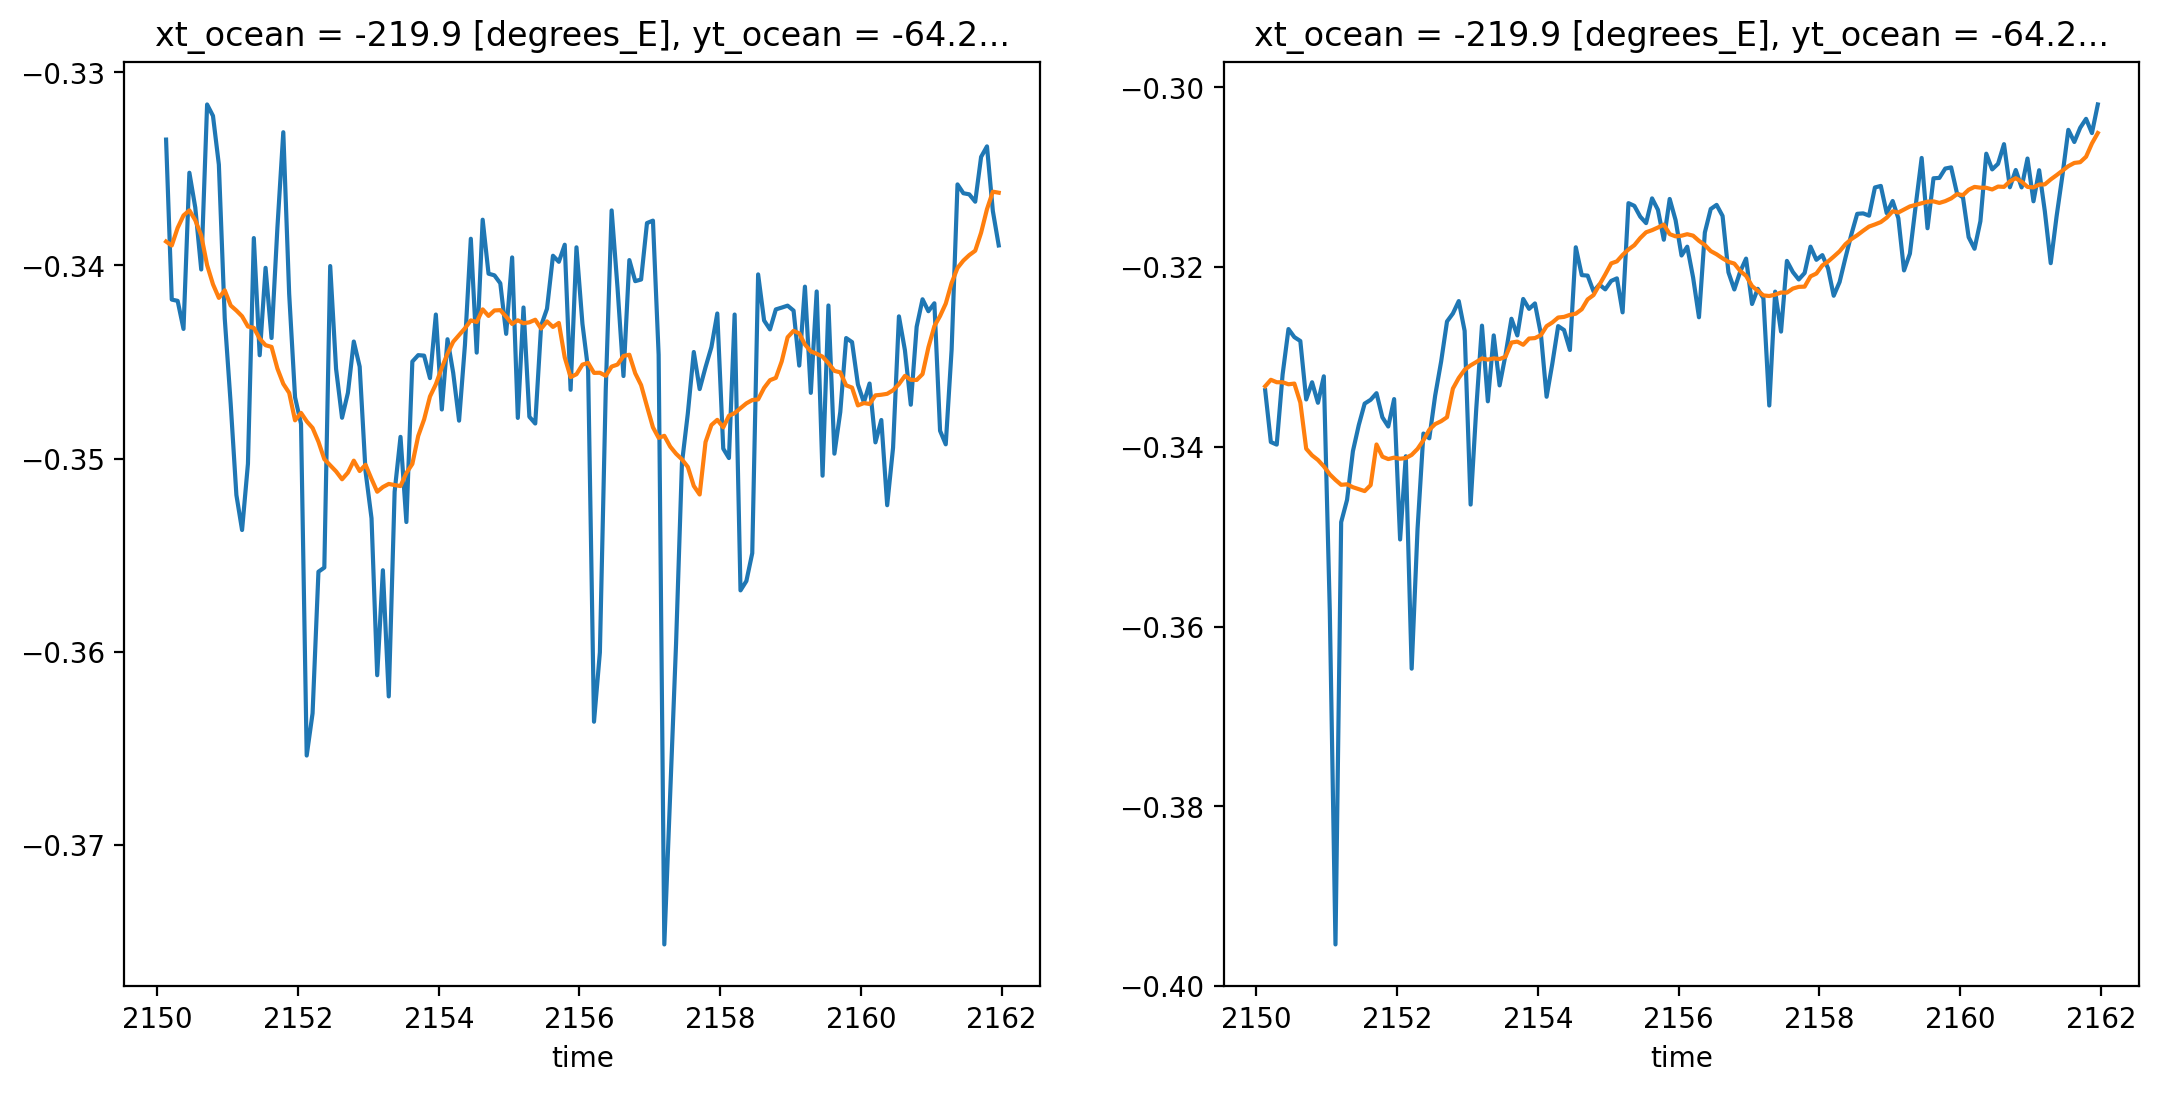

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,6))

temp_control.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[0])
temp_control_rolling_mean.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[0])

temp_eastdown.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[1])
temp_eastdown_rolling_mean.isel(xt_ocean=600, yt_ocean=400).plot(ax=axes[1])

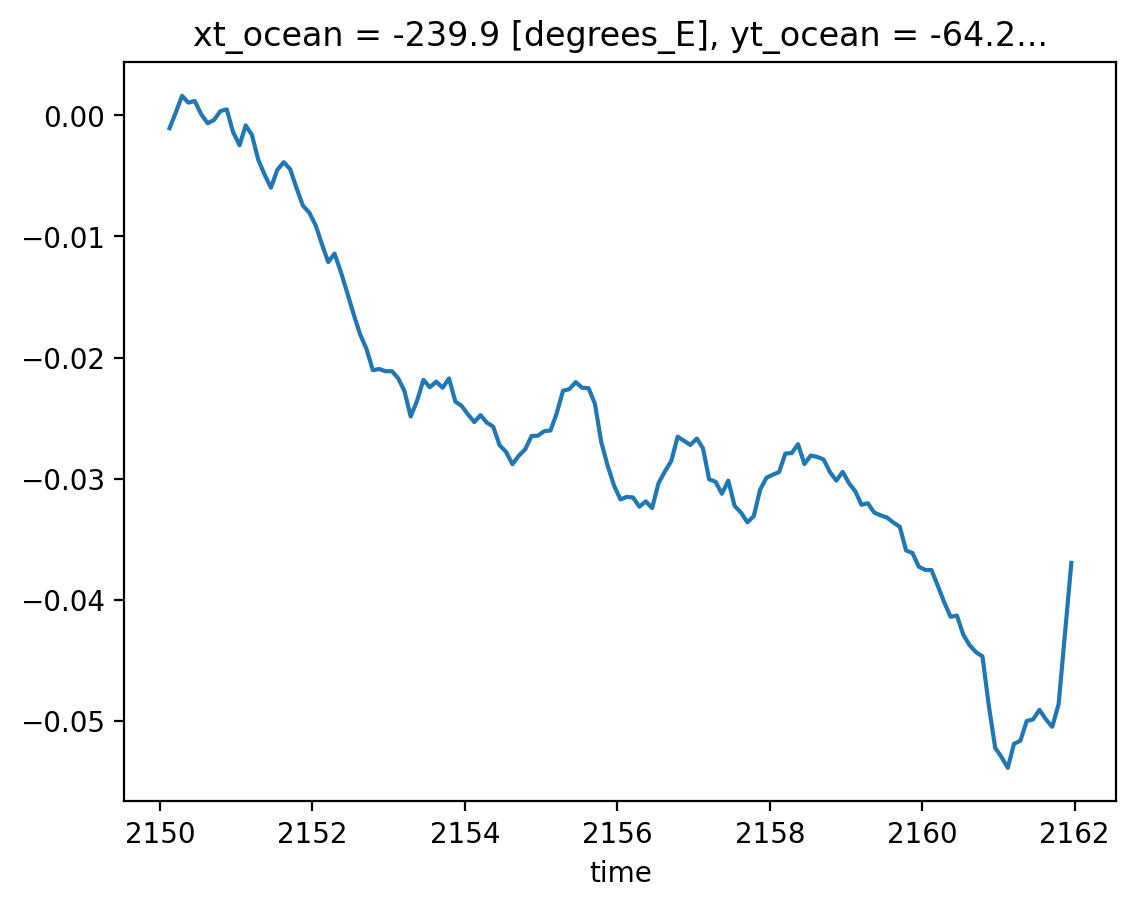

In [39]:
(temp_control_rolling_mean.isel(xt_ocean=400, yt_ocean=400)-temp_eastdown_rolling_mean.isel(xt_ocean=400, yt_ocean=400)).plot()

In [42]:
helper.annual_mean_from_monthly(temp_control_rolling_mean.isel(xt_ocean=400, yt_ocean=400)-temp_eastdown_rolling_mean.isel(xt_ocean=400, yt_ocean=400))

<xarray.DataArray ()> Size: 8B
array(-0.02592734)
Coordinates:
    xt_ocean  float64 8B -239.9
    yt_ocean  float64 8B -64.2
    geolon_t  float32 4B -239.9
    geolat_t  float32 4B -64.2
    variable  <U29 116B '__xarray_dataarray_variable__'

In [37]:
start_time = datetime.date(2150, 1, 16)

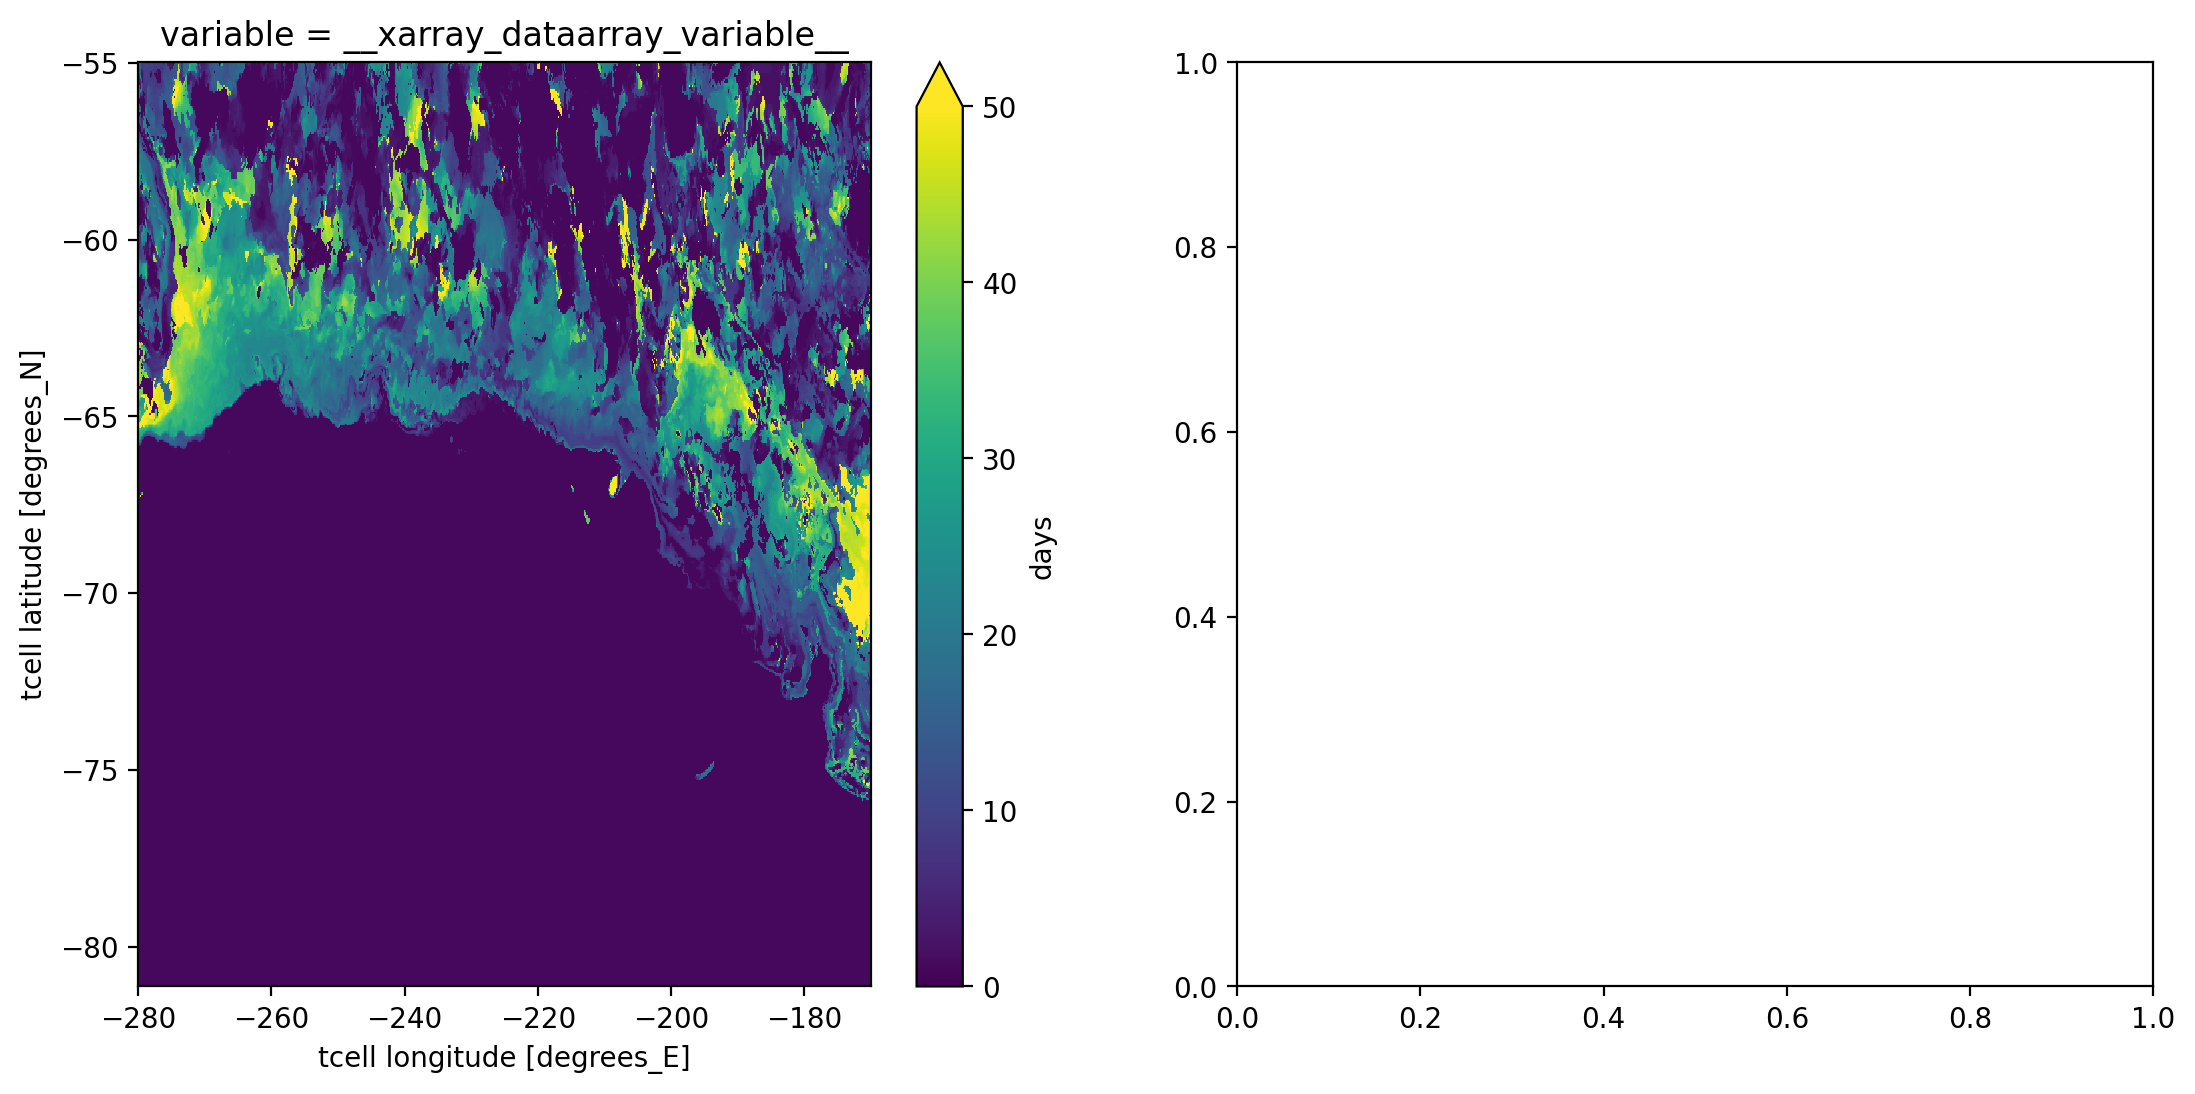

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,6))

((eastdown_timing_15-start_time).dt.days/30).plot(ax=axes[0], vmin=0, vmax=50)